In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
ds=pd.read_csv("dataset2.csv")

In [2]:
ds.shape

(1064, 20)

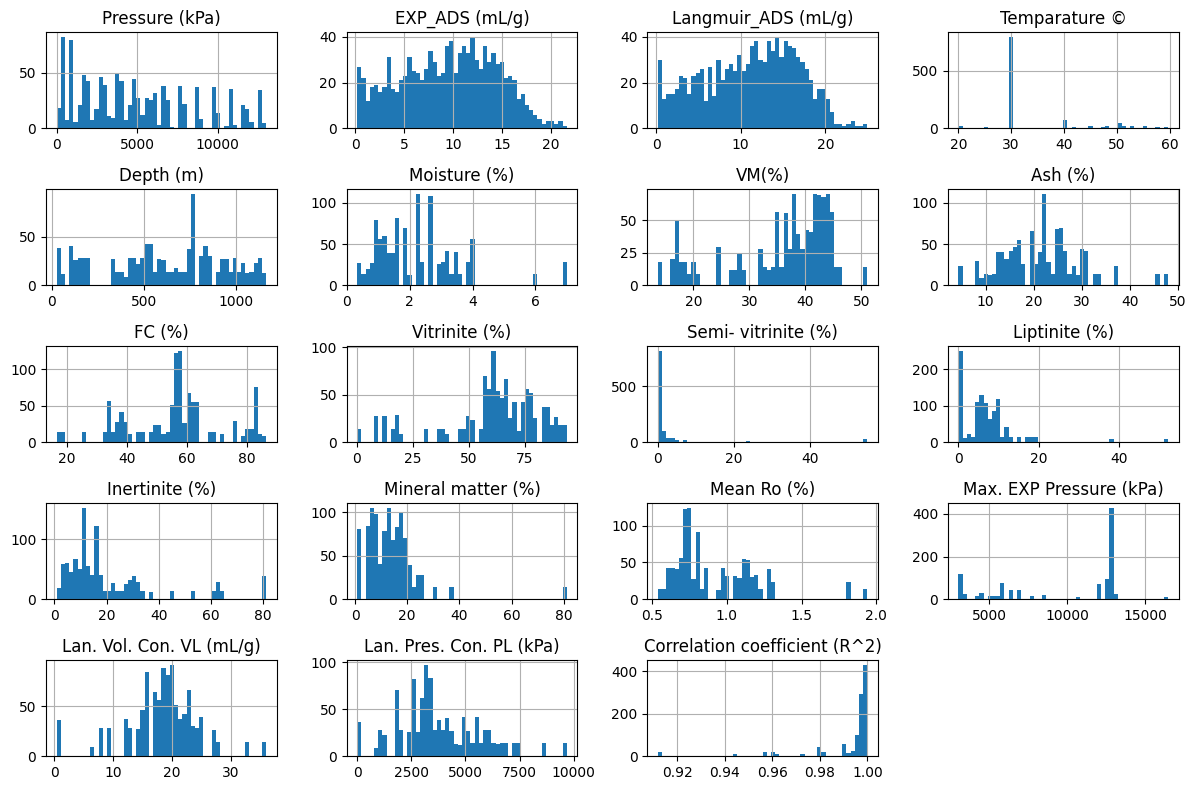

In [3]:
import matplotlib.pyplot as plt

ds.hist(bins=50, figsize=(12,8))
plt.tight_layout()
plt.savefig("ds_hist.png")
plt.show()


In [5]:
#lets scale the paramaters but to scale first i need to analyse the parameters 
#from the histogram, with simple analysis i selected different scaling methods for different features,mentioned in featureScaling.py file
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer

In [6]:
pressure_features = [
    "Pressure (kPa)",
    "Max. EXP Pressure (kPa)",
    "Lan. Pres. Con. PL (kPa)"
]



physical_features_standard = [
    "Temparature ©",
    "Mean Ro (%)"
]

physical_features_minmax = [
    "Depth (m)",
    "Moisture (%)",
    "VM(%)",
    "Ash (%)",
    "FC (%)",
    "Correlation coefficient (R^2)"
]


In [22]:
log_transformer = FunctionTransformer(
    func=np.log1p,
    validate=False,
    feature_names_out="one-to-one"  # This fixes the AttributeError
)

pressure_pipeline = Pipeline([
    ("log", log_transformer),
    ("scaler", RobustScaler())
])

physical_standard_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

physical_minmax_pipeline = Pipeline([
    ("scaler", MinMaxScaler())
])
adsorption_pipeline = Pipeline([
    ("log", log_transformer),
    ("scaler", RobustScaler())
])



In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("pressure", pressure_pipeline, pressure_features),
        ("physical_std", physical_standard_pipeline, physical_features_standard),
        ("physical_mm", physical_minmax_pipeline, physical_features_minmax),
    ],
    remainder="drop"
)


In [9]:
train_df, temp_df = train_test_split(
    ds, train_size=0.6, random_state=72
)

val_df, test_df = train_test_split(
    temp_df, train_size=0.5, random_state=17
)


In [10]:
target = "EXP_ADS (mL/g)"
drop_cols = [target, "Sample"]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target]

X_val = val_df.drop(columns=drop_cols)
y_val = val_df[target]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target]


In [11]:
X_train_scaled = preprocessor.fit_transform(X_train)

In [12]:
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)
#question: fit() vs transform(), notice why we used fit_transform on only trains but only transform on vals and test, because of data leakage


In [13]:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

Model                          | MAE        | RMSE       | R2 Score  
----------------------------------------------------------------------
Linear Regression              | 2.3374     | 3.0245     | 0.6178    
Random Forest                  | 0.7584     | 1.0978     | 0.9484    
Support Vector Regressor (SVR) | 1.2584     | 1.9581     | 0.8360    
Gradient Boosting              | 0.7253     | 0.9846     | 0.9592    
K-Nearest Neighbors            | 0.9533     | 1.4419     | 0.9116    


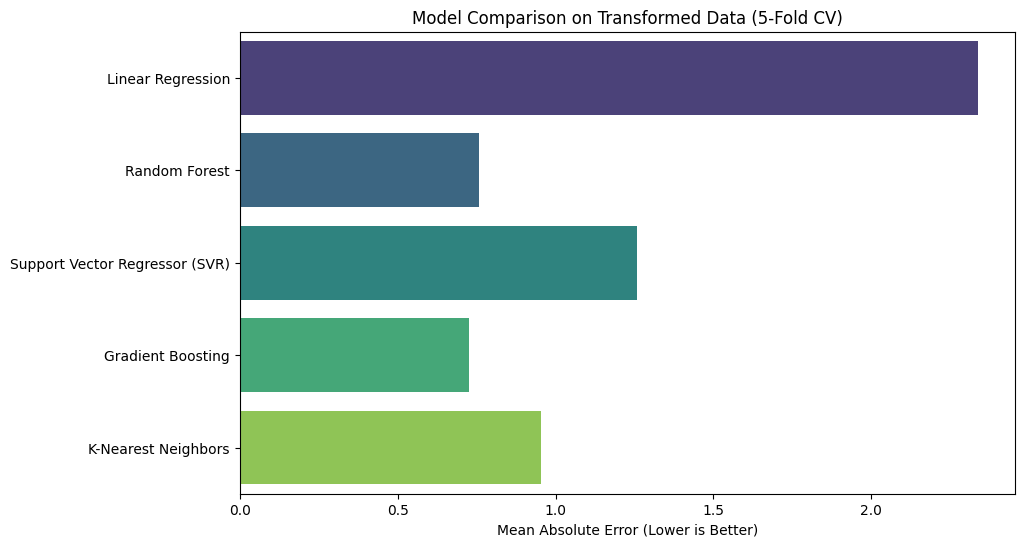

In [14]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define your models dictionary (Fixes the NameError)
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor (SVR)": SVR(C=1.0, epsilon=0.1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# 2. Setup Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=72)
mae_results = []
model_names = []

print(f"{'Model':<30} | {'MAE':<10} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 70)

for name, model in models.items():
    # Use the 'preprocessor' ColumnTransformer defined earlier
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('model', model)
    ])
    
    scoring = {
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'r2': 'r2'
    }
    
    # Run cross-validation on the RAW X_train so the pipeline can scale it properly
    cv_results = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=scoring)
    
    mae = -cv_results['test_mae'].mean()
    rmse = -cv_results['test_rmse'].mean()
    r2 = cv_results['test_r2'].mean()
    
    mae_results.append(mae)
    model_names.append(name)
    
    print(f"{name:<30} | {mae:<10.4f} | {rmse:<10.4f} | {r2:<10.4f}")

# 3. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=mae_results, y=model_names, hue=model_names, palette="viridis", legend=False)
plt.xlabel("Mean Absolute Error (Lower is Better)")
plt.title("Model Comparison on Transformed Data (5-Fold CV)")
plt.show()

Model (All Features)           | MAE        | RMSE       | R2 Score  
---------------------------------------------------------------------------
Linear Regression              | 1.1337     | 1.4676     | 0.9098    
Random Forest                  | 0.3421     | 0.4762     | 0.9902    
Support Vector Regressor (SVR) | 0.8168     | 1.3196     | 0.9273    
Gradient Boosting              | 0.3160     | 0.4206     | 0.9925    
K-Nearest Neighbors            | 1.1189     | 1.6099     | 0.8904    


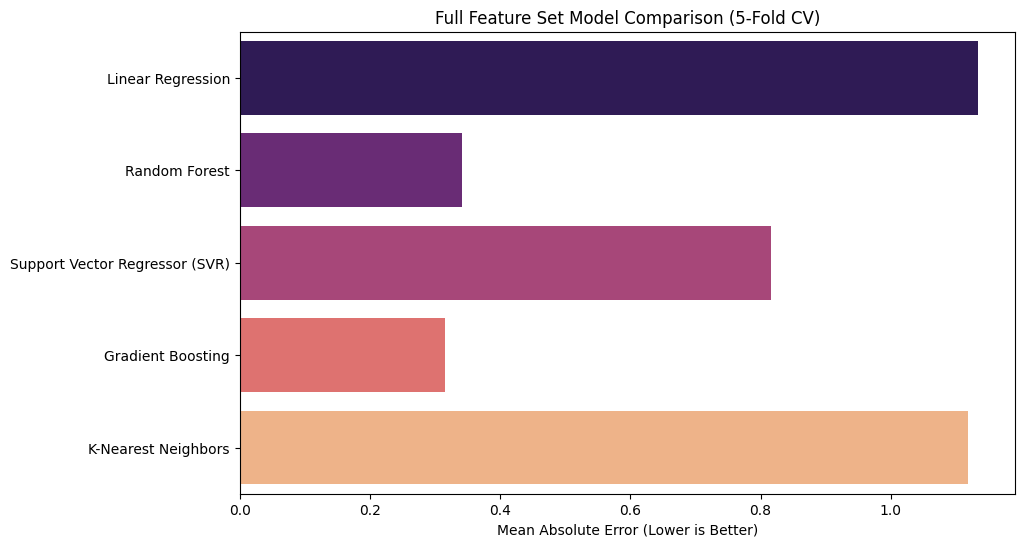

In [23]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Feature Lists with unique names
all_pressure_cols = [
    "Pressure (kPa)", 
    "Max. EXP Pressure (kPa)", 
    "Lan. Pres. Con. PL (kPa)"
]

all_adsorption_cols = [
    "Langmuir_ADS (mL/g)", 
    "Lan. Vol. Con. VL (mL/g)"
]

# Including macerals and correct "Temparature ©" spelling
all_phys_std_cols = [
    "Temparature ©", 
    "Mean Ro (%)",
    "Vitrinite (%)", 
    "Semi- vitrinite (%)", 
    "Liptinite (%)", 
    "Inertinite (%)", 
    "Mineral matter (%)"
]

all_phys_mm_cols = [
    "Depth (m)", 
    "Moisture (%)", 
    "VM(%)", 
    "Ash (%)", 
    "FC (%)", 
    "Correlation coefficient (R^2)"
]

# 2. Unique Preprocessor Name
preprocessor_all_feats = ColumnTransformer(
    transformers=[
        ("pressure", pressure_pipeline, all_pressure_cols),
        ("adsorption", adsorption_pipeline, all_adsorption_cols),
        ("physical_std", physical_standard_pipeline, all_phys_std_cols),
        ("physical_mm", physical_minmax_pipeline, all_phys_mm_cols),
    ],
    remainder="drop"
)

# 3. Unique Models Dictionary Name
models_comparison_all = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor (SVR)": SVR(C=1.0, epsilon=0.1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# 4. Cross-Validation with unique result names
kf_all = KFold(n_splits=5, shuffle=True, random_state=72)
mae_scores_all = []
names_all = []

print(f"{'Model (All Features)':<30} | {'MAE':<10} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 75)

for name, model in models_comparison_all.items():
    pipe_all = Pipeline([
        ('preprocessor', preprocessor_all_feats), 
        ('model', model)
    ])
    
    scoring_all = {
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'r2': 'r2'
    }
    
    cv_metrics_all = cross_validate(pipe_all, X_train, y_train, cv=kf_all, scoring=scoring_all)
    
    avg_mae = -cv_metrics_all['test_mae'].mean()
    avg_rmse = -cv_metrics_all['test_rmse'].mean()
    avg_r2 = cv_metrics_all['test_r2'].mean()
    
    mae_scores_all.append(avg_mae)
    names_all.append(name)
    
    print(f"{name:<30} | {avg_mae:<10.4f} | {avg_rmse:<10.4f} | {avg_r2:<10.4f}")

# 5. Visualization with unique plot title
plt.figure(figsize=(10, 6))
sns.barplot(x=mae_scores_all, y=names_all, hue=names_all, palette="magma", legend=False)
plt.xlabel("Mean Absolute Error (Lower is Better)")
plt.title("Full Feature Set Model Comparison (5-Fold CV)")
plt.show()

Feature Importance Analysis:
                          Feature  Importance (%)
3             Langmuir_ADS (mL/g)       90.628531
1         Max. EXP Pressure (kPa)        7.069113
2        Lan. Pres. Con. PL (kPa)        0.913701
4        Lan. Vol. Con. VL (mL/g)        0.452144
16                         FC (%)        0.229057
8             Semi- vitrinite (%)        0.225415
0                  Pressure (kPa)        0.150572
15                        Ash (%)        0.148442
12                      Depth (m)        0.052709
17  Correlation coefficient (R^2)        0.041971
13                   Moisture (%)        0.028534
7                   Vitrinite (%)        0.018488
14                          VM(%)        0.014820
6                     Mean Ro (%)        0.011639
10                 Inertinite (%)        0.011341
11             Mineral matter (%)        0.001874
9                   Liptinite (%)        0.000949
5                   Temparature ©        0.000698


C:\Users\susmi\AppData\Local\Temp\ipykernel_6016\1773890437.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance (%)', y='Feature', palette='viridis')


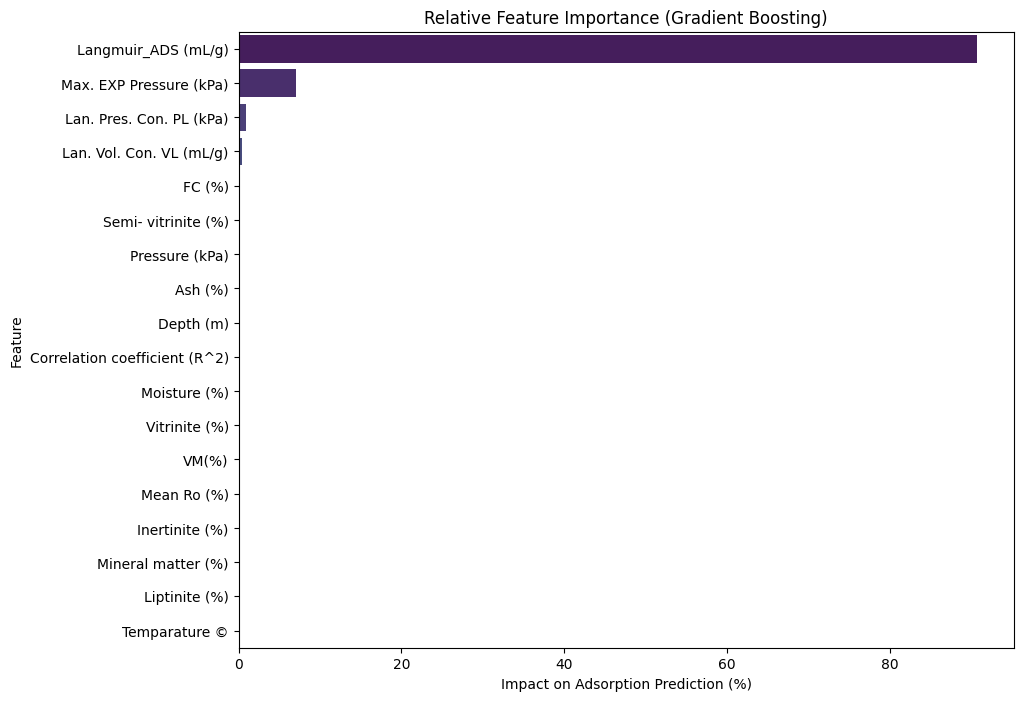

In [24]:
best_model_pipe = Pipeline([
    ('preprocessor', preprocessor_all_feats), 
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# 2. Fit it on your training data (or the whole dataset for production)
best_model_pipe.fit(X_train, y_train)
# 1. Now this call will work because 'log' knows its feature names
all_feature_names = best_model_pipe.named_steps['preprocessor'].get_feature_names_out()

# 2. Clean up names for the table
cleaned_names = [name.split('__')[-1] for name in all_feature_names]

# 3. Extract and format importance data
importances = best_model_pipe.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': cleaned_names,
    'Importance (%)': importances * 100
}).sort_values(by='Importance (%)', ascending=False)

# 4. Display Results
print("Feature Importance Analysis:")
print(importance_df)

# 5. Visualize
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance (%)', y='Feature', palette='viridis')
plt.title('Relative Feature Importance (Gradient Boosting)')
plt.xlabel('Impact on Adsorption Prediction (%)')
plt.show()

In [27]:

best_model_pipe2 = Pipeline([
    ('preprocessor', preprocessor_all_feats), 
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# 2. Fit it on your training data (or the whole dataset for production)
best_model_pipe2.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pressure', ...), ('adsorption', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Feature Importance Analysis:
                          Feature  Importance (%)
3             Langmuir_ADS (mL/g)       90.628531
1         Max. EXP Pressure (kPa)        7.069113
2        Lan. Pres. Con. PL (kPa)        0.913701
4        Lan. Vol. Con. VL (mL/g)        0.452144
16                         FC (%)        0.229057
8             Semi- vitrinite (%)        0.225415
0                  Pressure (kPa)        0.150572
15                        Ash (%)        0.148442
12                      Depth (m)        0.052709
17  Correlation coefficient (R^2)        0.041971
13                   Moisture (%)        0.028534
7                   Vitrinite (%)        0.018488
14                          VM(%)        0.014820
6                     Mean Ro (%)        0.011639
10                 Inertinite (%)        0.011341
11             Mineral matter (%)        0.001874
9                   Liptinite (%)        0.000949
5                   Temparature ©        0.000698


C:\Users\susmi\AppData\Local\Temp\ipykernel_6016\3853219817.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance (%)', y='Feature', palette='viridis')


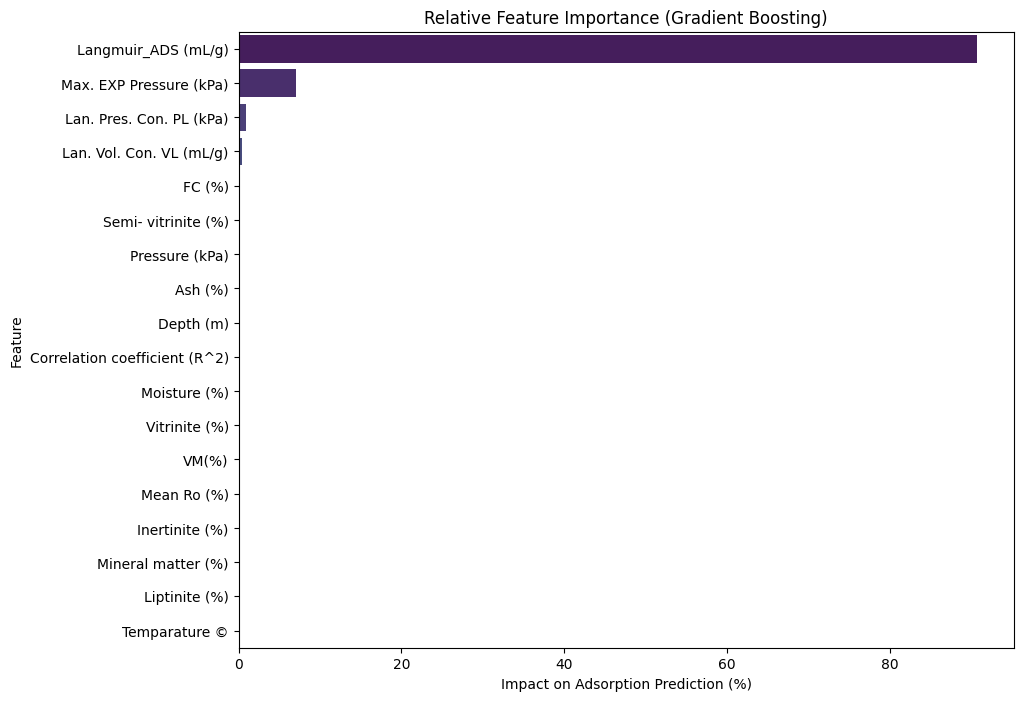

In [28]:
# 1. Now this call will work because 'log' knows its feature names
all_feature_names = best_model_pipe2.named_steps['preprocessor'].get_feature_names_out()

# 2. Clean up names for the table
cleaned_names = [name.split('__')[-1] for name in all_feature_names]

# 3. Extract and format importance data
importances = best_model_pipe2.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': cleaned_names,
    'Importance (%)': importances * 100
}).sort_values(by='Importance (%)', ascending=False)

# 4. Display Results
print("Feature Importance Analysis:")
print(importance_df)

# 5. Visualize
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance (%)', y='Feature', palette='viridis')
plt.title('Relative Feature Importance (Gradient Boosting)')
plt.xlabel('Impact on Adsorption Prediction (%)')
plt.show()

the results clearly suggest that the model is more sensitive towards langmouir ads which is a theoritical value calculated by the formula that involves volume and pressure, its okay but 90% contribution is bad, we have to remove that column and re train a better model. Model3 is where i compared these with and without langmuir adds column. check it out